<a href="https://colab.research.google.com/github/janakg/era-s5/blob/main/S5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F

In [14]:
import os

# Define the repository and the target directory
repo_url = 'https://github.com/janakg/era-s5.git'
target_dir = '/content/era-s5'

# Check if the directory already exists
if not os.path.exists(target_dir):
    # If it doesn't exist, clone the repo
    !git clone {repo_url}
else:
    # If it exists, 'cd' into the directory and pull the latest changes
    %cd {target_dir}
    !git pull

# Add the repository's directory to the system path
import sys
sys.path.append(target_dir)

# Import all utils functions
from utils import *

fatal: destination path 'era-s5' already exists and is not an empty directory.


CODE BLOCK: 2

In [15]:
# CUDA?
use_cuda = torch.cuda.is_available()
print("CUDA Available?", use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")

CUDA Available? True


CODE BLOCK: 3

In [16]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [17]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

CODE BLOCK: 5

In [18]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

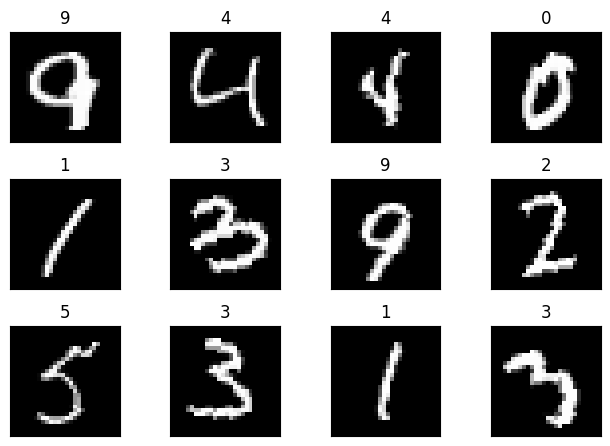

In [19]:
# Call the util function to show a batch of images
import matplotlib.pyplot as plt
fig = plt.figure()
show_batch_images(plt, train_loader, 12, 3, 4)

CODE BLOCK: 7

In [20]:
# model imported from a module
from model import Net

CODE BLOCK: 8

In [21]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [22]:

# All utils are imported from utils.py module       

CODE BLOCK: 10

In [23]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss
num_epochs = 1

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_succeeded, train_processed, train_loss = train(model, device, train_loader, optimizer, criterion)
  train_acc.append(100 * train_succeeded/train_processed)
  train_losses.append(train_loss / len(train_loader))

  test_succeeded, test_loss = test(model, device, test_loader, criterion)
  test_acc.append(100. * test_succeeded / len(test_loader.dataset))
  test_losses.append(test_loss)

  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.7241 Batch_id=117 Accuracy=37.94: 100%|██████████| 118/118 [00:10<00:00, 11.46it/s]


Test set: Average loss: 0.4917, Accuracy: 8449/10000 (84.49%)

Adjusting learning rate of group 0 to 1.0000e-02.


CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

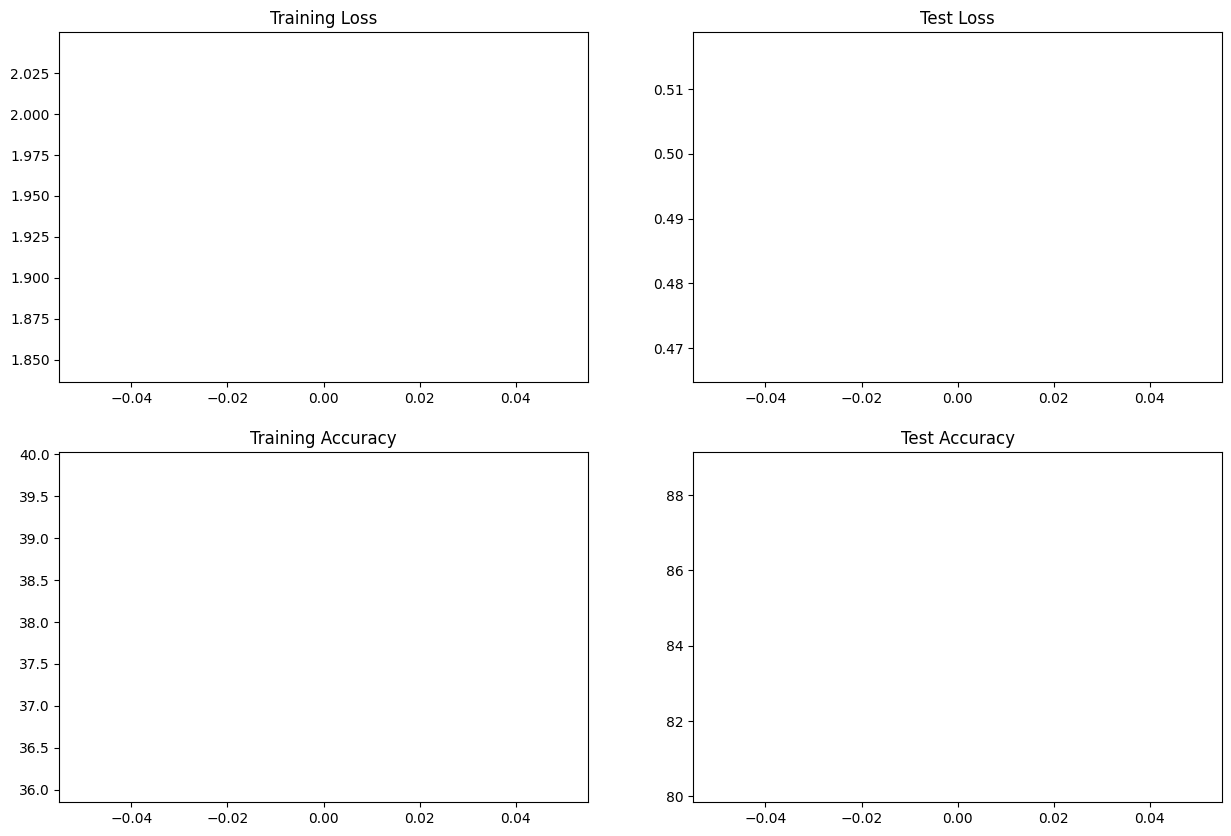

In [24]:
# Plots
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [25]:
!pip install torchsummary
from torchsummary import summary
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
